In [1]:
import numpy as np 
import pandas as pd
import os

# Para representación gráfica
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Label encoding para la variable: 'actividad'

Se le asignarán valores numéricos asociados a cada tipo de actividad

- **0**: 'brazos-alante-atras'
- **1**: 'brazos-arriba-abajo'
- **2**: 'brazos-circulos'
- **3**: 'flexion-mano-hombro'
- **4**: 'jumping-jacks'
- **5**: 'rodillas-pecho'
- **6**: 'sentadilla-brazos-ext'

In [585]:
df = pd.read_csv('df_conjunto.csv')
df

,Timestamp,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,actividad,user
0,0.000000,-0.270532,1.845952,-0.646680,0.226296,0.774562,-1.092600,brazos_alante_atras,usuario1
1,0.060463,-0.025424,1.506042,-0.785994,-0.659153,0.874743,-2.375112,brazos_alante_atras,usuario1
2,0.123759,0.323665,1.355996,-0.807446,0.362825,1.314872,-2.930083,brazos_alante_atras,usuario1
3,0.166524,0.764674,1.076785,-0.826969,0.774242,1.456287,-3.458482,brazos_alante_atras,usuario1
4,0.206668,0.987240,1.029198,-0.830826,0.708574,1.273944,-4.038498,brazos_alante_atras,usuario1
...,...,...,...,...,...,...,...,...,...
74721,39.735607,0.571445,-0.046074,-1.200563,-0.591520,0.644232,-0.830963,sentadilla_brazos_ext,usuario11
74722,39.774034,0.545503,0.287466,-1.570542,-0.899396,0.359874,-1.152584,sentadilla_brazos_ext,usuario11
74723,39.809487,0.426220,0.140334,-1.443520,-0.340759,0.621325,-0.687105,sentadilla_brazos_ext,usuario11
74724,39.844067,0.745764,0.287224,-1.682862,-0.694450,0.355293,-0.316309,sentadilla_brazos_ext,usuario11


In [587]:
le = LabelEncoder()
df['act_encoded'] = le.fit_transform(df['actividad'])

In [583]:
df['user'].unique()

array(['javier', 'javier2', 'javier3', 'lupe', 'nico', 'mama', 'chema',
       'suso', 'xavi', 'nico_maestre', 'tomas'], dtype=object)

In [589]:
df['user'].unique()

array(['usuario1', 'usuario2', 'usuario3', 'usuario4', 'usuario5',
       'usuario6', 'usuario7', 'usuario8', 'usuario9', 'usuario10',
       'usuario11'], dtype=object)

In [877]:
df['actividad'].unique()

array(['brazos_alante_atras', 'brazos_arriba_abajo', 'brazos_circulos',
       'flexion_mano_hombro', 'jumping_jacks', 'rodillas_pecho',
       'sentadilla_brazos_ext'], dtype=object)

In [591]:
train_users = ['usuario1','usuario8','usuario10','usuario5','usuario6','usuario11','usuario4']
val_users = ['usuario7','usuario2']
test_users = ['usuario9','usuario3']

In [593]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleraciones
    N_FEATURES = 6
    segments = []
    labels = []

    # Primero se convierten los datos en una lista
    for i in range(0, len(df) - time_steps, step):
        ax = df['Acc_X'].values[i: i + time_steps]
        ay = df['Acc_Y'].values[i: i + time_steps]
        az = df['Acc_Z'].values[i: i + time_steps]
        
        gx = df['Gyro_X'].values[i: i + time_steps]
        gy = df['Gyro_Y'].values[i: i + time_steps]
        gz = df['Gyro_Z'].values[i: i + time_steps]
        
        # Lo etiquetamos como la actividad más frecuente 
        label = stats.mode(df[label_name][i: i + time_steps])[0]

        # Añadimos cada segmento con su label correspondiente
        segments.append([ax,ay,az,gx,gy,gz])
        labels.append(label)
    
    # Primero, se convierten las listas a arrays, con np.asarray.
    # Luego, los pasamos a vector con las dimensiones adecuadas haciendo un reshape
    segments = np.asarray(segments, dtype= np.float32)
    reshaped_segments = segments.reshape(-1, time_steps, N_FEATURES)
    
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [595]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib


def preprocess_data(df_train, df_test, TIME_STEPS, STEP_DISTANCE, LABEL, N_FEATURES):
    
    # Crear segmentos y etiquetas para los datos de entrenamiento y prueba
    X_train, y_train = create_segments_and_labels(df_train, TIME_STEPS, STEP_DISTANCE, LABEL)
    X_val, y_val = create_segments_and_labels(df_val, TIME_STEPS, STEP_DISTANCE, LABEL)
    X_test, y_test = create_segments_and_labels(df_test, TIME_STEPS, STEP_DISTANCE, LABEL)

    # Escalar las características utilizando StandardScaler. Se debe hacer un reshape ya que los datos están en 3D (segmentos,
    # filas y columnas) y el scaler espera que los datos estén en 2D. Luego se deshace el cambio haciendo otro reshape.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, N_FEATURES)).reshape(-1, TIME_STEPS, N_FEATURES)
    
    # Save the scaler to disk (same way as you saved the model)
    joblib.dump(scaler, 'scaler.pkl')

    X_val = scaler.transform(X_val.reshape(-1, N_FEATURES)).reshape(-1, TIME_STEPS, N_FEATURES)
    X_test = scaler.transform(X_test.reshape(-1, N_FEATURES)).reshape(-1, TIME_STEPS, N_FEATURES)

    # Codificación one-hot para las etiquetas
    cat_encoder = OneHotEncoder(sparse_output=False)
    
    # Remodelar y_train y y_test a 2D antes de aplicar la codificación one-hot
    y_train_hot = cat_encoder.fit_transform(y_train.reshape(-1, 1))
    y_train = y_train_hot

    y_val = cat_encoder.transform(y_val.reshape(-1, 1))  
    
    y_test_hot = cat_encoder.fit_transform(y_test.reshape(-1, 1))
    y_test = y_test_hot
    
    return X_train, y_train, X_val, y_val, X_test, y_test

## Red neuronal

In [181]:
def custom_model_4(X_train, y_train):
    model = Sequential()

    kernel_size = 7
    
    model.add(Input(shape=(TIME_STEPS, N_FEATURES)))
    
    model.add(Conv1D(64,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Dropout(0.5))

    # model.add(Conv1D(160,kernel_size=kernel_size,activation='relu'))
    model.add(Conv1D(100,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(160,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    print(model.summary())

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        # validation_split=validation_split,
        validation_data=validation_data,
        verbose=1
    )

    return model, history

In [51]:
def custom_save_model(X_train, y_train, run_number):
    model = Sequential()

    kernel_size = 7
    
    model.add(Input(shape=(TIME_STEPS, N_FEATURES)))
    
    model.add(Conv1D(64,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Dropout(0.5))

    # model.add(Conv1D(160,kernel_size=kernel_size,activation='relu'))
    model.add(Conv1D(100,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(160,kernel_size=kernel_size,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    # model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # Guardar el modelo
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"model_run_{run_number}.keras")

    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        # validation_split=validation_split,
        validation_data=validation_data,
        verbose=0, 
        callbacks=[checkpoint]
    )
    # Guardar el modelo final en formato .keras
    final_model_path = os.path.join(model_dir, f"final_model_run_{run_number}.keras")
    model.save(final_model_path)

    return model, history

### Best model

So far, best model is **custom_model_2** with:
- batch_size = 16
- 100, 160 filters
- kernel_size = 7
- epochs = 100
- validation_split = 0.2

In [54]:


df_train = df[df['user'].isin(train_users)]
df_val = df[df['user'].isin(val_users)]
df_test = df[df['user'].isin(test_users)]

# Tamaño del conjunto de train y test

print(f'Train: {df_train.shape[0] / df.shape[0]:.4f}')
print(f'Val: {df_val.shape[0] / df.shape[0]:.4f}')
print(f'Test: {df_test.shape[0] / df.shape[0]:.4f}')

Train: 0.6518
Val: 0.1788
Test: 0.1694


In [183]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, ConvLSTM1D, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization,MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
import time

TIME_STEPS = 80
STEP_DISTANCE = int(TIME_STEPS/2)
LABEL = 'act_encoded'
N_FEATURES = 6

n_runs = 100

# Se crean el conjunto de entrenamiento y test
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_test, TIME_STEPS, STEP_DISTANCE, LABEL, N_FEATURES)

num_classes = 7
batch_size = 16
epochs = 70
validation_data = (X_val, y_val)

model, history = custom_model_4(X_train, y_train)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 74, 64)              │           2,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 37, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 31, 100)             │          44,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 15, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 15, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 9, 160)              │         112,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 4, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 7)                   │           4,487 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,299 (641.79 KB)

 Trainable params: 164,299 (641.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1967 - loss: 2.0047 - val_accuracy: 0.4925 - val_loss: 1.6272
Epoch 2/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3656 - loss: 1.6570 - val_accuracy: 0.6727 - val_loss: 1.2488
Epoch 3/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5142 - loss: 1.3563 - val_accuracy: 0.7417 - val_loss: 0.9532
Epoch 4/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6110 - loss: 1.1045 - val_accuracy: 0.6907 - val_loss: 0.8055
Epoch 5/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6563 - loss: 0.9636 - val_accuracy: 0.8438 - val_loss: 0.6250
Epoch 6/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7231 - loss: 0.7543 - val_accuracy: 0.8408 - val_loss: 0.5299
Epoch 7/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7797 - loss: 0.6091 - val_accuracy: 0.8709 - val_loss: 0.4664
Epoch 8/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8021 - loss: 0.5671 - val_accuracy: 0.8859 - val

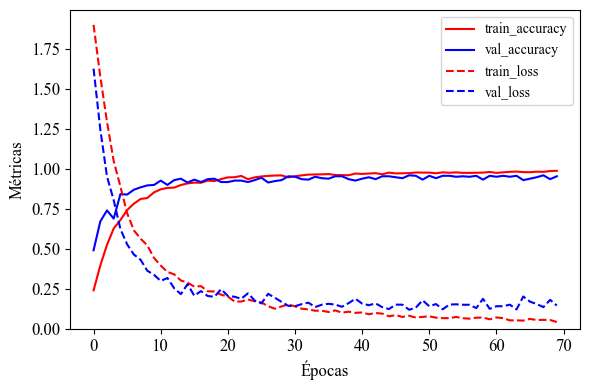

In [184]:
#%% Visualización entrenamiento
from sklearn.metrics import classification_report

fontsize = 12

plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["axes.labelsize"] = 14  # Tamaño de las etiquetas de los ejes
plt.rcParams["xtick.labelsize"] = fontsize  # Tamaño de los números en el eje X
plt.rcParams["ytick.labelsize"] = fontsize  # Tamaño de los números en el eje Y


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='train_accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='val_accuracy')
plt.plot(history.history['loss'], 'r--', label='train_loss')
plt.plot(history.history['val_loss'], 'b--', label='val_loss')
# plt.title('Model Accuracy and Loss')
plt.ylabel('Métricas',fontsize=fontsize)
plt.xlabel('Épocas',fontsize=fontsize)
plt.ylim(0)

plt.legend()
# Mostrar gráficos
plt.tight_layout()
plt.savefig(f"curva_aprendizaje.svg", format="svg")
plt.show()

In [61]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9835 - loss: 0.0754 
Test accuracy 0.9460317492485046
Test loss 0.15945445001125336


In [803]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, ConvLSTM1D, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization,MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

TIME_STEPS = 80
STEP_DISTANCE = int(TIME_STEPS/2)
LABEL = 'act_encoded'
N_FEATURES = 6

n_runs = 20

# Se crean el conjunto de entrenamiento y test
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_test, TIME_STEPS, STEP_DISTANCE, LABEL, N_FEATURES)

num_classes = 7
batch_size = 16
epochs = 100
# validation_split = 0.2
validation_data = (X_val, y_val)

# Archivo para guardar las métricas
metrics_file = "metrics.txt"
with open(metrics_file, "w") as f:
    f.write("Run, Model, Accuracy, Validation Accuracy, Loss, Validation Loss\n")

# Registrar el tiempo inicial total
total_start_time = time.time()

# Ejecución del modelo n veces
for run_number in range(1, n_runs + 1):
    print(f"Entrenando modelo {run_number}/{n_runs}...")

    model, history = custom_save_model(X_train, y_train, run_number)

    # Obtener métricas
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Guardar métricas en el archivo
    with open(metrics_file, "a") as f:
        f.write(f"{run_number}, model_run_{run_number}.keras, {accuracy}, {val_accuracy}, {loss}, {val_loss}\n")

    print(f"Modelo {run_number} completado y guardado.")

total_elapsed_time = time.time() - total_start_time
total_minutes = int(total_elapsed_time // 60)
total_seconds = total_elapsed_time % 60

print(f"\nEntrenamiento finalizado. Tiempo total tardado: {total_minutes}m {total_seconds:.2f}s.")
print("Las métricas se han guardado en 'metrics.txt' y los modelos en la carpeta 'models'.")



Entrenando modelo 1/20...
Modelo 1 completado y guardado.
Entrenando modelo 2/20...
Modelo 2 completado y guardado.
Entrenando modelo 3/20...
Modelo 3 completado y guardado.
Entrenando modelo 4/20...
Modelo 4 completado y guardado.
Entrenando modelo 5/20...
Modelo 5 completado y guardado.
Entrenando modelo 6/20...
Modelo 6 completado y guardado.
Entrenando modelo 7/20...
Modelo 7 completado y guardado.
Entrenando modelo 8/20...
Modelo 8 completado y guardado.
Entrenando modelo 9/20...
Modelo 9 completado y guardado.
Entrenando modelo 10/20...
Modelo 10 completado y guardado.
Entrenando modelo 11/20...
Modelo 11 completado y guardado.
Entrenando modelo 12/20...
Modelo 12 completado y guardado.
Entrenando modelo 13/20...
Modelo 13 completado y guardado.
Entrenando modelo 14/20...
Modelo 14 completado y guardado.
Entrenando modelo 15/20...
Modelo 15 completado y guardado.
Entrenando modelo 16/20...
Modelo 16 completado y guardado.
Entrenando modelo 17/20...
Modelo 17 completado y guardado

In [832]:
from keras.models import load_model

test_accuracies = []

for i in range(1,21):
    model = load_model(f'models/final_model_run_{i}.keras')

    test_loss, test_acc = model.evaluate(X_test, y_test)
    test_accuracies.append(test_acc) 
    
    print("Test accuracy", test_acc)
    print("Test loss", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9777 - loss: 0.0949
Test accuracy 0.9428571462631226
Test loss 0.1803329586982727
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9642 - loss: 0.1142
Test accuracy 0.9555555582046509
Test loss 0.1716330200433731
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9675 - loss: 0.1084
Test accuracy 0.9460317492485046
Test loss 0.18049976229667664
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9795 - loss: 0.0900
Test accuracy 0.9492063522338867
Test loss 0.1670793890953064
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9730 - loss: 0.0812
Test accuracy 0.958730161190033
Test loss 0.15484030544757843
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9835 - loss: 0.0737
Test accuracy 0.9460317492485046
Test loss 0.18580840528011322
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9769 - loss: 0.0817
Test accuracy 0.9396825432777405
Test loss 0.17436718940734863
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc

In [834]:
test_accuracies

[0.9428571462631226,
 0.9555555582046509,
 0.9460317492485046,
 0.9492063522338867,
 0.958730161190033,
 0.9460317492485046,
 0.9396825432777405,
 0.9555555582046509,
 0.958730161190033,
 0.958730161190033,
 0.958730161190033,
 0.9523809552192688,
 0.9492063522338867,
 0.958730161190033,
 0.9269841313362122,
 0.9333333373069763,
 0.9428571462631226,
 0.9460317492485046,
 0.9365079402923584,
 0.9523809552192688]

In [127]:
from tensorflow.keras.models import load_model

for i in range(1,21):
    print(i)
    best_model = load_model(f'models/model_run_{i}.keras')
    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    print("Test accuracy", test_acc)
    print("Test loss", test_loss)



1
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9765 - loss: 0.1247  
Test accuracy 0.9333333373069763
Test loss 0.2431756854057312
2
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9775 - loss: 0.1135  
Test accuracy 0.9269841313362122
Test loss 0.22161145508289337
3
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9798 - loss: 0.1033
Test accuracy 0.9396825432777405
Test loss 0.22168639302253723
4
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9823 - loss: 0.0997
Test accuracy 0.9428571462631226
Test loss 0.19867271184921265
5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9783 - loss: 0.0789  
Test accuracy 0.9396825432777405
Test loss 0.15781031548976898
6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9835 - loss: 0.0802  
Test accuracy 0.9460317492485046
Test loss 0.18274059891700745
7
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9739 - loss: 0.0957
Test accuracy 0.9301587343215942
Test loss 0.19933289289474487
8
10/10 ━━━━━━━━━━━━━━━━━

In [473]:
best_model = load_model('models/model_run_9.keras')
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9880 - loss: 0.0692  
Test accuracy 0.961904764175415
Test loss 0.1448059231042862


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


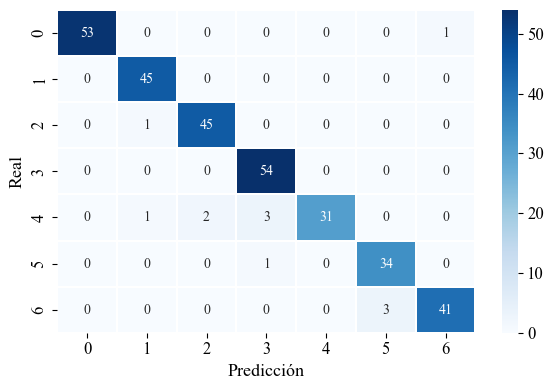

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.96      1.00      0.98        45
           2       0.96      0.98      0.97        46
           3       0.93      1.00      0.96        54
           4       1.00      0.84      0.91        37
           5       0.92      0.97      0.94        35
           6       0.98      0.93      0.95        44

    accuracy                           0.96       315
   macro avg       0.96      0.96      0.96       315
weighted avg       0.96      0.96      0.96       315



In [474]:
import seaborn as sns
from sklearn import metrics

def show_confusion_matrix(validations, predictions):
    plt.rcParams["font.family"] = "Times New Roman"
    fontsize=13

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=0.1,
                # xticklabels=LABELS,
                # yticklabels=LABELS,
                annot=True,
                fmt='d')

    # plt.title('Confusion Matrix')
    plt.ylabel('Real', fontsize=fontsize)
    plt.xlabel('Predicción',fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"conf_matrix.svg", format="svg")
    plt.show()

y_pred_test = best_model.predict(X_test)
# y_pred_test = model.predict(X_test)
# Toma la clase con la mayor probabilidad a partir de las predicciones de la prueba
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [436]:
model.save('Best_model.keras')

In [438]:
from keras.models import load_model

best_model = load_model('Best_model.keras')

In [440]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9151 - loss: 0.1826  
Test accuracy 0.960132896900177
Test loss 0.09015988558530807


## Modelo MLP

In [521]:
def mlp(X_train, y_train, run_number):
    model = Sequential()

    model.add(Input(shape=(TIME_STEPS, N_FEATURES)))
    
    model.add(Flatten())

    model.add(Dense(500, activation='relu'))
    # model.add(Dropout(0.3))
              
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())

        # Guardar el modelo
    model_dir = "mlp_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"model_run_{run_number}.keras")

    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        # validation_split=validation_split,
        validation_data=validation_data,
        verbose=0, 
        callbacks=[checkpoint]
    )
    # Guardar el modelo final en formato .keras
    final_model_path = os.path.join(model_dir, f"final_model_run_{run_number}.keras")
    model.save(final_model_path)

    return model, history


In [526]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, ConvLSTM1D, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization,MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

TIME_STEPS = 80
STEP_DISTANCE = int(TIME_STEPS/2)
LABEL = 'act_encoded'
N_FEATURES = 6

# Se crean el conjunto de entrenamiento y test
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(df_train, df_test, TIME_STEPS, STEP_DISTANCE, LABEL, N_FEATURES)

num_classes = 7
batch_size = 16
epochs = 70
validation_data = (X_val, y_val)

n_runs = 20


# model, history = mlp(X_train, y_train)
# model, history = perceptron(X_train, y_train)

# Archivo para guardar las métricas
metrics_file = "mlp_metrics.txt"
with open(metrics_file, "w") as f:
    f.write("Run, Model, Accuracy, Validation Accuracy, Loss, Validation Loss\n")

# Registrar el tiempo inicial total
total_start_time = time.time()

# Ejecución del modelo n veces
for run_number in range(1, n_runs + 1):
    print(f"Entrenando modelo {run_number}/{n_runs}...")

    model, history = mlp(X_train, y_train, run_number)

    # Obtener métricas
    accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Guardar métricas en el archivo
    with open(metrics_file, "a") as f:
        f.write(f"{run_number}, model_run_{run_number}.keras, {accuracy}, {val_accuracy}, {loss}, {val_loss}\n")

    print(f"Modelo {run_number} completado y guardado.")

total_elapsed_time = time.time() - total_start_time
total_minutes = int(total_elapsed_time // 60)
total_seconds = total_elapsed_time % 60

print(f"\nEntrenamiento finalizado. Tiempo total tardado: {total_minutes}m {total_seconds:.2f}s.")
print("Las métricas se han guardado en 'metrics.txt' y los modelos en la carpeta 'models'.")

Entrenando modelo 1/20...


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 1 completado y guardado.
Entrenando modelo 2/20...


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_36 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 2 completado y guardado.
Entrenando modelo 3/20...


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_37 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 3 completado y guardado.
Entrenando modelo 4/20...


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_38 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 4 completado y guardado.
Entrenando modelo 5/20...


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_39 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 5 completado y guardado.
Entrenando modelo 6/20...


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_40 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 6 completado y guardado.
Entrenando modelo 7/20...


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_41 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 7 completado y guardado.
Entrenando modelo 8/20...


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_42 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 8 completado y guardado.
Entrenando modelo 9/20...


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_43 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 9 completado y guardado.
Entrenando modelo 10/20...


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_44 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 10 completado y guardado.
Entrenando modelo 11/20...


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_45 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 11 completado y guardado.
Entrenando modelo 12/20...


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_46 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 12 completado y guardado.
Entrenando modelo 13/20...


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_47 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 13 completado y guardado.
Entrenando modelo 14/20...


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_48 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 14 completado y guardado.
Entrenando modelo 15/20...


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_49 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 15 completado y guardado.
Entrenando modelo 16/20...


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_50 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 16 completado y guardado.
Entrenando modelo 17/20...


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_51 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 17 completado y guardado.
Entrenando modelo 18/20...


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_52 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 18 completado y guardado.
Entrenando modelo 19/20...


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_53 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 19 completado y guardado.
Entrenando modelo 20/20...


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_54 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Modelo 20 completado y guardado.

Entrenamiento finalizado. Tiempo total tardado: 13m 38.39s.
Las métricas se han guardado en 'metrics.txt' y los modelos en la carpeta 'models'.


In [551]:
from tensorflow.keras.models import load_model

mlp_test_acc =  []

for i in range(1,21):
    print(i)
    best_model = load_model(f'mlp_models/model_run_{i}.keras')
    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    mlp_test_acc.append(test_acc)
    print("Test accuracy", test_acc)
    print("Test loss", test_loss)

1
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9006 - loss: 0.4357  
Test accuracy 0.8730158805847168
Test loss 0.6663776636123657
2
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9038 - loss: 0.3364  
Test accuracy 0.8984127044677734
Test loss 0.4783984124660492
3
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9223 - loss: 0.3317  
Test accuracy 0.882539689540863
Test loss 0.6395307183265686
4
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8969 - loss: 0.3235  
Test accuracy 0.8761904835700989
Test loss 0.4223898649215698
5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8930 - loss: 0.3322  
Test accuracy 0.8666666746139526
Test loss 0.39264705777168274
6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9111 - loss: 0.3005  
Test accuracy 0.8888888955116272
Test loss 0.4508654475212097
7
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9195 - loss: 0.3169  
Test accuracy 0.8920634984970093
Test loss 0.43192002177238464
8
10/10 ━━━━━━━━━━━━━━━━━━

In [570]:
model, history = mlp(X_train, y_train)

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_57 (Flatten)                 │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 494,507 (1.89 MB)

 Trainable params: 494,507 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4834 - loss: 1.4478 - val_accuracy: 0.8348 - val_loss: 0.4970
Epoch 2/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9458 - loss: 0.1958 - val_accuracy: 0.7928 - val_loss: 0.5322
Epoch 3/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9667 - loss: 0.1046 - val_accuracy: 0.8619 - val_loss: 0.4918
Epoch 4/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9799 - loss: 0.0504 - val_accuracy: 0.8679 - val_loss: 0.4328
Epoch 5/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9919 - loss: 0.0245 - val_accuracy: 0.8589 - val_loss: 0.4884
Epoch 6/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9921 - loss: 0.0304 - val_accuracy: 0.8559 - val_loss: 0.5165
Epoch 7/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9824 - loss: 0.0528 - val_accuracy: 0.8318 - val_loss: 0.5782
Epoch 8/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0463 - val_accuracy: 0.8258 - val

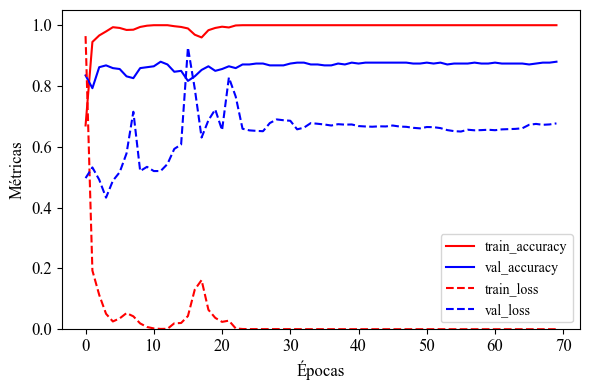

In [573]:
#%% Visualización entrenamiento
from sklearn.metrics import classification_report

fontsize = 12

plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["axes.labelsize"] = 14  # Tamaño de las etiquetas de los ejes
plt.rcParams["xtick.labelsize"] = fontsize  # Tamaño de los números en el eje X
plt.rcParams["ytick.labelsize"] = fontsize  # Tamaño de los números en el eje Y


plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='train_accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='val_accuracy')
plt.plot(history.history['loss'], 'r--', label='train_loss')
plt.plot(history.history['val_loss'], 'b--', label='val_loss')
# plt.title('Model Accuracy and Loss')
plt.ylabel('Métricas',fontsize=fontsize)
plt.xlabel('Épocas',fontsize=fontsize)
plt.ylim(0)

plt.legend()
# Mostrar gráficos
plt.tight_layout()
plt.savefig(f"curva_aprendizaje_mlp.svg", format="svg")
plt.show()

In [577]:
from keras.models import load_model

best_mlp_model = load_model('mlp_models/model_run_8.keras')

test_loss, test_acc = best_mlp_model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9192 - loss: 0.3029  
Test accuracy 0.9015873074531555
Test loss 0.42218250036239624


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


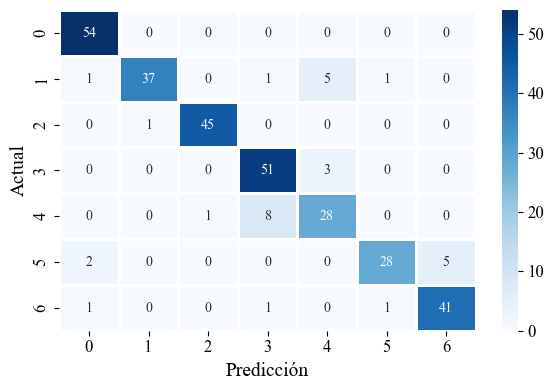

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       0.97      0.82      0.89        45
           2       0.98      0.98      0.98        46
           3       0.84      0.94      0.89        54
           4       0.78      0.76      0.77        37
           5       0.93      0.80      0.86        35
           6       0.89      0.93      0.91        44

    accuracy                           0.90       315
   macro avg       0.90      0.89      0.89       315
weighted avg       0.90      0.90      0.90       315



In [579]:
import seaborn as sns
from sklearn import metrics

def show_confusion_matrix(validations, predictions):
    plt.rcParams["font.family"] = "Times New Roman"
    fontsize=14

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=1,
                # xticklabels=LABELS,
                # yticklabels=LABELS,
                annot=True,
                fmt='d')
    # plt.title('Confusion Matrix')
    plt.ylabel('Actual', fontsize=fontsize)
    plt.xlabel('Predicción',fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"mlp_conf_matrix.svg", format="svg")
    plt.show()

y_pred_test = best_mlp_model.predict(X_test)
# Toma la clase con la mayor probabilidad a partir de las predicciones de la prueba
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [428]:
print(f'Train: {df_train.shape[0] / df.shape[0]:.4f}')
print(f'Val: {df_val.shape[0] / df.shape[0]:.4f}')
print(f'Test: {df_test.shape[0] / df.shape[0]:.4f}')

Train: 0.6518
Val: 0.1788
Test: 0.1694
